## Prepare Dataset

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

raw_csv_data = pd.read_csv('DataSets/2019/intraday_2019_01_5min_IBM.csv')
raw_csv_data = raw_csv_data[::-1]

print(raw_csv_data)

#features = ['unix_timestamp', 'close', 'volume']
features = ['unix_timestamp', 'open', 'high', 'low', 'close', 'volume'] # full

# Create DataFrame
df = pd.DataFrame(raw_csv_data, columns=
    features
)
df = df.astype(float)

# Convert the datetime to Unix timestamp (in seconds)
df['unix_timestamp'] = pd.to_datetime(raw_csv_data['timestamp']).astype('int64') // 10**9

#print(df.head(10))

# Handle missing values
#df = df.ffill()  # Forward fill missing values

#time_features = df['unix_timestamp'].apply(timestamp_to_features).apply(pd.Series)
#df = pd.concat([df, time_features], axis=1)

print(df)

# Normalization
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled_data = scaler.fit_transform(df[features])
# 
# print("scaled:")
# print(scaled_data[0:5])
# print(scaled_data[-6:-1])

# Create sequences (using 60 time steps to predict next value)
# Sliding-Window over the dataset, to give ML more context
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, [4,5]])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # 5 hours of history (60 * 5min)

# Define feature column indices (adjust based on your data)
# feature_columns = {
#     'unix_timestamp': 0,
#     'close': 1,
#     'volume': 2
# }
feature_columns = {features[i] : i for i in range(len(features))}

# Split data PROPERLY
split_idx = int(0.8 * len(df))
train_raw = df.iloc[:split_idx]
test_raw = df.iloc[split_idx:]

# Scale using TRAINING DATA ONLY
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(train_raw)
scaled_test = scaler.transform(test_raw)

print(type(scaled_train))

# Create sequences
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)

time_step = scaled_train[1][0] - scaled_train[0][0]
print("time step: ", time_step)

print("ytest:\n", y_test)

# X, y = create_sequences(scaled_data, SEQ_LENGTH)
# 
# # Split into train/test
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
# 
# # 1. Split raw data first
# train_raw = df.iloc[:split]
# test_raw = df.iloc[split:]
# print(np.min(train_raw.index))
# print(np.max(test_raw.index))
# assert np.min(train_raw.index) > np.max(test_raw.index)

print(X_train[-1][0:, 0])
print(X_test[0][0:, 0])

#print(X_train[0][0:, 0])

# print("X:")
# print(X[0])
# print("\ny:")
# print(y)

                timestamp     open     high      low    close  volume
2232  2019-01-02 06:25:00  80.4920  80.4920  80.4920  80.4920     104
2231  2019-01-02 07:00:00  80.5996  80.6355  80.5996  80.6355     648
2230  2019-01-02 07:10:00  80.6068  80.6068  80.6068  80.6068     104
2229  2019-01-02 07:35:00  80.9153  80.9153  80.9153  80.9153     313
2228  2019-01-02 08:00:00  80.6426  80.6426  80.6426  80.6426     261
...                   ...      ...      ...      ...      ...     ...
4     2019-01-31 18:10:00  96.6420  96.6420  96.6420  96.6420     627
3     2019-01-31 18:20:00  96.6420  96.6420  96.4985  96.4985     941
2     2019-01-31 18:25:00  96.6420  96.6420  96.6420  96.6420     104
1     2019-01-31 19:00:00  96.6420  96.6420  96.6420  96.6420     507
0     2019-01-31 19:15:00  96.6420  96.6420  96.6420  96.6420     320

[2233 rows x 6 columns]
      unix_timestamp     open     high      low    close  volume
2232      1546410300  80.4920  80.4920  80.4920  80.4920   104.0
2231 

## Prepare LSTM AI

In [28]:
import torch
import torch.nn as nn

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

print("Is cuda available:", torch.cuda.is_available())  # Should return True
print(torch.version.cuda)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For mixed precision training (optional but recommended)
grad_scaler = torch.amp.GradScaler(init_scale=2.**16)

class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 2) # output size
        # self.fc_mu = nn.Linear(hidden_size, 2)  # Mean predictions
        # self.fc_var = nn.Linear(hidden_size, 2) # Variance
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last time step's output
        return out

# Hyperparameters
model = StockPredictor(
    input_size=len(features),   # (timestamp, open, high, low, close, volume)
    hidden_size=128, # Increases training time 
    num_layers=4 # Increases training time
).to(device)

# Optional: Enable cudnn optimizations
# torch.backends.cudnn.benchmark = True

CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4080
Is cuda available: True
12.8
Using device: cuda


## Training

In [29]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to TensorDataset
train_dataset = TensorDataset(
    torch.Tensor(X_train).to(device),
    torch.Tensor(y_train).to(device)
)

# Use pinned memory and multiple workers
train_loader = DataLoader(
    train_dataset,
    batch_size=2048,  # Adjust based on GPU memory
    shuffle=False,
    num_workers=0,
)

class VolatilityWeightedLoss(nn.Module): # Custom loss function (Unused)
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets):
        # Calculate volatility weights
        price_changes = targets[:,0] - inputs[:,0]
        weights = torch.abs(price_changes) * 5  # Amplify large moves
        
        # Weighted MSE
        return torch.mean(weights * (inputs - targets)**2)

In [30]:
criterion = nn.MSELoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200): # More epoch -> more trained (takes longer)
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Automatic mixed precision
        with torch.amp.autocast(device.type):
            outputs = model(batch_X)
            # Add Gaussian noise (1% of price range)
            noise = torch.randn_like(outputs) * 0.002
            outputs += noise
            loss = criterion(outputs, batch_y)
        
        # Scaled backpropagation
        optimizer.zero_grad(set_to_none=True)  # More memory efficient
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 10, Loss: 0.1790
Epoch 20, Loss: 0.1121
Epoch 30, Loss: 0.0358
Epoch 40, Loss: 0.0183
Epoch 50, Loss: 0.0122
Epoch 60, Loss: 0.0107
Epoch 70, Loss: 0.0099
Epoch 80, Loss: 0.0096
Epoch 90, Loss: 0.0095
Epoch 100, Loss: 0.0094
Epoch 110, Loss: 0.0094
Epoch 120, Loss: 0.0093
Epoch 130, Loss: 0.0093
Epoch 140, Loss: 0.0093
Epoch 150, Loss: 0.0093
Epoch 160, Loss: 0.0092
Epoch 170, Loss: 0.0092
Epoch 180, Loss: 0.0092
Epoch 190, Loss: 0.0091
Epoch 200, Loss: 0.0091


## Evaluate

In [35]:
def autoregressive_predict(model, scaler, initial_sequence, true_test_data, feature_columns):
    """
    Simulates real-world prediction without future data access
    - initial_sequence: Last SEQ_LENGTH training samples (scaled)
    - true_test_data: Actual test data for comparison (scaled)
    - feature_columns: Indices of [open, high, low, close, volume]
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(len(true_test_data)):
        # Predict next close price
        with torch.no_grad():
            inputs = torch.Tensor(current_sequence).unsqueeze(0).to(device)
            pred_scaled = model(inputs).squeeze().cpu().numpy()
            
        # Store prediction
        predictions.append(pred_scaled)
        
        # Create new feature vector (critical!)
        new_features = np.zeros(len(current_sequence[0]))
        
        pred_close_price = pred_scaled[0]
        pred_vol = pred_scaled[1]
        
        # Calculate timestamp (previous timestamp + 5min)
        last_timestamp = current_sequence[-1, feature_columns['unix_timestamp']]
        new_timestamp = last_timestamp + time_step  # 5 minutes in seconds
        new_features[feature_columns['unix_timestamp']] = new_timestamp
        
       # Add realistic noise (0.5% of current price)
        noise_scale = abs(pred_close_price * 0.05)
        pred_close_price += np.random.normal(0, noise_scale)
        
        # Estimated OHLC (using predicted close as all values)
        new_features[feature_columns['open']] = pred_close_price
        new_features[feature_columns['high']] = pred_close_price
        new_features[feature_columns['low']] = pred_close_price
        new_features[feature_columns['close']] = pred_close_price
        
        # Volume handling (set to 0 or average)
        new_features[feature_columns['volume']] = pred_vol  # Or use historical average
        
        # Update sequence (remove oldest, add new prediction)
        current_sequence = np.vstack([current_sequence[1:], new_features])
    
    return predictions

In [36]:
import matplotlib.pyplot as plt
def visualize_predictions(model, scaler, train_data, test_data, seq_length, feature_columns):
    # Get initial sequence (last training samples)
    initial_sequence = train_data[-seq_length:]
    
    #print(initial_sequence[::20])
    
    # Make autoregressive predictions
    test_predictions = np.array(autoregressive_predict(
        model, scaler, initial_sequence, 
        test_data, feature_columns
    ))
    
    #print(test_predictions[::20])
    
    # Inverse scaling for meaningful values
    def inverse_scale(preds, scaler, data_shape):
        dummy = np.zeros((len(preds), data_shape))
        #dummy[:, 0] = preds[:, 0]  # 'timestamp' is at index 0
        dummy[:, feature_columns['close']] = preds[:, 0]  # 'close' is at index 4
        #dummy[:, 5] = preds[:, 1]  # 'vol' is at index 5
        return scaler.inverse_transform(dummy)[:, feature_columns['close']]
    
    # # Inverse scaling
    # def inverse_scale_pred(pred, scaler, feature_columns):
    #     dummy = np.zeros((3, df.shape[1]))
    #     dummy[:, feature_columns['close']] = pred
    #     return scaler.inverse_transform(dummy)[0, feature_columns['close']]
    
    # Convert predictions to actual prices
    pred_prices = inverse_scale(test_predictions, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in test_predictions]
    true_prices = scaler.inverse_transform(test_data)[:, feature_columns['close']]
    
    # Create timeline
    train_timestamps = df.index[seq_length:len(train_data)]
    test_timestamps = df.index[len(train_data):len(train_data)+len(test_data)]
    
    plt.figure(figsize=(16, 8))
    
    # Plot historical data
    plt.plot(df.index[:len(train_data)], 
             scaler.inverse_transform(train_data)[:, feature_columns['close']], 
             label='Historical Prices', alpha=0.4)
    
    X_train_timestamps = df.index[seq_length:len(X_train)]
    # Plot training predictions
    train_sequences = torch.Tensor(X_train).to(device)
    with torch.no_grad():
        train_preds = model(train_sequences).squeeze().cpu().numpy()
    #print(train_preds[::20])
    # full_inputs = torch.Tensor(train_data).to(device)
    # train_preds = model(full_inputs).detach().cpu().numpy()
    train_pred_prices = inverse_scale(train_preds, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in train_preds[seq_length:]]
    #print(train_pred_prices)
    plt.plot(train_timestamps, train_pred_prices, 
             label='Training Fit', linestyle='--')
    
    # Plot test predictions
    plt.plot(test_timestamps, pred_prices, 
             label='Autoregressive Predictions', linewidth=2)
    
    # Plot actual test prices
    plt.plot(test_timestamps, true_prices, 
             label='True Future Prices', alpha=0.7)
    
    plt.axvline(x=test_timestamps[0], color='black', 
                linestyle='--', label='Prediction Start')
    plt.gca().invert_xaxis()
    plt.title('Realistic Stock Price Prediction Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pred_prices, true_prices

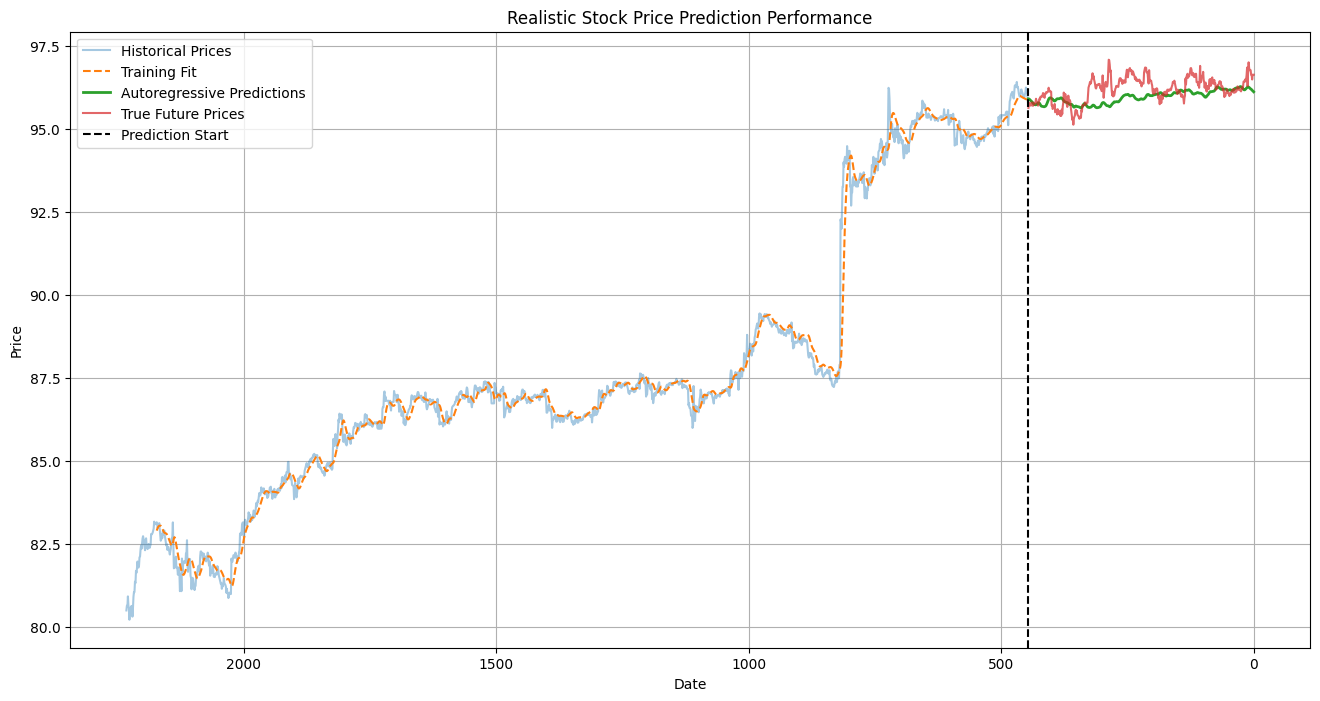

In [37]:
# Evaluate properly
model.eval()
pred_prices, true_prices = visualize_predictions(
    model, scaler, scaled_train, scaled_test, 
    SEQ_LENGTH, feature_columns
)

# Calculate metrics
# rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
# mae = mean_absolute_error(true_prices, pred_prices)
# direction_acc = np.mean(np.diff(true_prices) * np.diff(pred_prices) > 0)

# print(f"""
# Realistic Performance Report:
# - RMSE: {rmse:.2f}
# - MAE: {mae:.2f}
# - Direction Accuracy: {direction_acc*100:.1f}%
# """)